**Fase 2 do TCC**

Já com os dados equilibrados feito no tcc-1  https://www.kaggle.com/rafaelgimenes/tcc-1


In [1]:
#imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils.np_utils import to_categorical
from PIL import Image
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import os
print('data sets',os.listdir("../input"))
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import itertools

Using TensorFlow backend.


data sets ['img_isic_eq_224x224', 'metadata_isic_eq.csv']


In [2]:
#pastas com imagens
print(os.listdir("../input/img_isic_eq_224x224"))

['HAM10000', 'MSK-2', 'MSK-3', 'MSK-4', '2018 JID Editorial Images', 'UDA-2', 'UDA-1', 'MSK-1']


Leitura do dataset, esse data-set foi equilibrado/balanceado no tcc-1

In [3]:
#data set vindo do kaggle tcc_1
df = pd.read_csv("../input/metadata_isic_eq.csv")

In [4]:
df.head()

,image_id,image_name,created,dataset_id,dataset_name,width,height,age,sex,benign_malignant,diagnosis,diagnosis_confirm_type,melanocytic,updated,age_range
0,5436e3acbae478396759f0d3,ISIC_0000002,2014-10-09T19:36:12.152000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1022,767,60.0,Female,malignant,melanoma,histopathology,True,2015-02-23T02:48:37.249000+00:00,[60 - 70)
1,5436e3acbae478396759f0d7,ISIC_0000004,2014-10-09T19:36:12.315000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1022,767,80.0,Male,malignant,melanoma,histopathology,True,2015-02-23T02:48:57.303000+00:00,[90 - 100)
2,5436e3adbae478396759f0e9,ISIC_0000013,2014-10-09T19:36:13.062000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1022,767,30.0,Female,malignant,melanoma,histopathology,True,2015-02-23T02:50:26.544000+00:00,[20 - 30)
3,5436e3aebae478396759f0fb,ISIC_0000022,2014-10-09T19:36:14.060000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1504,1129,55.0,Female,malignant,melanoma,histopathology,True,2015-02-23T02:52:14.911000+00:00,[60 - 70)
4,5436e3aebae478396759f103,ISIC_0000026,2014-10-09T19:36:14.537000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1504,1129,30.0,Female,malignant,melanoma,histopathology,True,2015-02-23T02:53:24.115000+00:00,[20 - 30)


Criação da coluna Y, nosso target é binario '**benign_malignant**' nessa coluna vamos trasformar pra um atributo INTEIRO. 
Sendo criando a coluna y 0=do bem, 1 = do mal.

In [5]:
#criando a coluna y 0=do bem, 1 = do mal.
df['y'] = -1
df.y[df.benign_malignant == 'benign'] = 0
df.y[df.benign_malignant == 'malignant'] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [6]:
df.head()

,image_id,image_name,created,dataset_id,dataset_name,width,height,age,sex,benign_malignant,diagnosis,diagnosis_confirm_type,melanocytic,updated,age_range,y
0,5436e3acbae478396759f0d3,ISIC_0000002,2014-10-09T19:36:12.152000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1022,767,60.0,Female,malignant,melanoma,histopathology,True,2015-02-23T02:48:37.249000+00:00,[60 - 70),1
1,5436e3acbae478396759f0d7,ISIC_0000004,2014-10-09T19:36:12.315000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1022,767,80.0,Male,malignant,melanoma,histopathology,True,2015-02-23T02:48:57.303000+00:00,[90 - 100),1
2,5436e3adbae478396759f0e9,ISIC_0000013,2014-10-09T19:36:13.062000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1022,767,30.0,Female,malignant,melanoma,histopathology,True,2015-02-23T02:50:26.544000+00:00,[20 - 30),1
3,5436e3aebae478396759f0fb,ISIC_0000022,2014-10-09T19:36:14.060000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1504,1129,55.0,Female,malignant,melanoma,histopathology,True,2015-02-23T02:52:14.911000+00:00,[60 - 70),1
4,5436e3aebae478396759f103,ISIC_0000026,2014-10-09T19:36:14.537000+00:00,5a2ecc5e1165975c945942a2,UDA-1,1504,1129,30.0,Female,malignant,melanoma,histopathology,True,2015-02-23T02:53:24.115000+00:00,[20 - 30),1


Separando os datasets em Benign e Malign para comparmos os 2

In [7]:
#separando os malignos e benignos
dfM = df.loc[(df['benign_malignant'] == 'malignant') ]
dfB = df.loc[(df['benign_malignant'] == 'benign') ]

Fazendo uma comparação pra ver se temos um data-set equilibrado

In [8]:
#verificando se eles estão balanceados
totalMx = pd.DataFrame( {'Malignos': dfM.groupby(('age_range')).size()} )
totalBx = pd.DataFrame( {'Bening': dfB.groupby(('age_range')).size() } )
frames = [totalMx, totalBx]
totalTx = pd.concat(frames,axis=1)
totalTx['Diff'] = totalTx['Bening'] -  totalTx['Malignos']

In [9]:
totalTx

,Malignos,Bening,Diff
age_range,,,
[-10 - 0),98,108,10
[0 - 10),1,11,10
[10 - 20),13,23,10
[20 - 30),98,108,10
[30 - 40),66,76,10
[40 - 50),215,225,10
[50 - 60),167,177,10
[60 - 70),413,423,10
[70 - 80),272,272,0


**Transformando Imagens em números**

Pois bem, machine learning se baseia-se em números, e o que são imagens? são um conjunto de pixels que são representados por um byte que varia de 0-255, um valor RGB.
Então uma imagem pra nós será uma matriz de pixels, do tamanho da imagem, em nosso caso 224x244.


In [10]:
#agora vamos criar o X, o sera a nossa matriz de pixels.
pathImg = '../input/img_isic_eq_224x224/'

Vamos criar uma função, que recebe o path e abre a imagem já convertendo ela pra matriz RGB, estamos utilizando a biblioteca do python PIL 

> from PIL import Image

In [11]:
#funcao lambda de leitura da imagem 
readToRGB = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

Por algum motivo desconhecido essa imagem estava gerando um erro de leitura, gerando uma exception, como foi somente ela, não achamos a necessario criar uma função pra remover a imagem do data-set.
Se isso se repetisse muitas vezes, com certeza compensaria fazer um função pra dropar isso automaticamente.

In [12]:
#removendo imagem corrompida
df.drop(df.loc[df['image_name']=='ISIC_0024416'].index, inplace=True)

**Retornando a Matriz RGB**

Apesar de mais verboso, ficou mais fácil de entender do que usar uma expressão lambda.
* Criação da matriz de Pixels
* iteração no dataset para montar o path do arquivo
* chamada da função que abre o arquivo e converte pra matriz RGB
* adiciona a matriz na lista de matrizes.


In [13]:
#caregando as imagens
matrizPixels = []

# interando sobre o dataset, usando a função join pra montar o path, e usando a função read para ler o
# ler o JPG transformando e matriz  RGB, e apendando na matrix de pixels.
for index, row in df.iterrows():
    m = readToRGB(os.path.join(pathImg,row['dataset_name'],row['image_name']+'.jpg'))
    matrizPixels.append(m)

Verificando os data-sets

In [14]:
#comparando a matriz de pixels e a e dataset 
print(len(matrizPixels))
print(df.shape)

4535
(4535, 16)


**Criando o X(input) e o y(target)**

In [15]:
# criando nosso X e y 
X = np.array(matrizPixels, dtype='uint8')
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
y = np.array(df['y'], dtype='uint8')
y = to_categorical(y, num_classes= 2)

Verificando o X e y

In [16]:
print('size X',len(X))
print('size y',len(y))

size X 4535
size y 4535


**Embaralhando os dados**

Como o data-frame(df) esta em ordem de data-set(nome da pasta), e possivelmente tem caracteristicas parecidas, nos resolvemos embaralhar os dados.

*Muito importante*
Considerando que o X e y, estão alinhados, se vamos embaralhar o X temos que garantir que o mesmo embaralhamento seja feito no y.

Para isso usamos o mesmo fator de shuffle nos 2.

In [17]:
#embaralhando tudo
factorRandom = np.arange(X.shape[0])
np.random.shuffle(factorRandom)
X = X[factorRandom]
y = y[factorRandom]

**Escalando as Imagens**

Para obtermos melhor resultado, vamos escalar as matrizes de 0-255 para 0-1.

In [18]:
#escalando o X, tranformando os valores entre 0 e 1.
X_scaled = X/255

**Separação dos Dados de Treino e Teste**

In [19]:
#train test split
X_train, X_test, y_train, y_test= train_test_split(X_scaled, 
                                                 y,
                                                 test_size=0.20,
                                                 random_state=42)

**Rede Neural CNN**

Agora iremos iniciar a utilização da rede convolucional.
Nesta etapa criaremos a função *build*, onde iremos parametrizar as camadas que serão utilizadas para o treinamento do modelo.

**Anotações**

*Camadas Conv2D:* Estas são camadas de convolução que irão lidar com as nossas imagens de entrada, que são vistas como matrizes bidimensionais.

*Camadas MaxPool2D:* Essa camada simplesmente age como um filtro de redução de resolução. Ele olha para os 2 pixels vizinhos e escolhe o valor máximo. Eles são usados ​​para reduzir o custo computacional e, de certa forma, também reduzem o overfitting.

*Camadas Dropout:* Esta camada é usada apenas na fase de treinamento, não no teste. Elimina um conjunto aleatório de ativações na camada setando para zero. Força a rede a ser “redundante” e a classificar corretamente mesmo que algumas ativações sejam zeradas.


**Referências**

https://www.youtube.com/watch?v=-7scQpJT7uo&frags=wn

http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

In [20]:
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2, init= 'normal', activ= 'relu', optim= 'adam'):
    
    model = Sequential()
        
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))    
   
    # Camada de Entrada    
    model.add(Flatten())
    
    # Camada oculta
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    
    # Camada de saída
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    
    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    # Antes de o modelo estar pronto para treinar, este precisa de mais algumas configurações. Estas são adicionadas no passo compile:
        #loss - Isto mede quão bem o modelo classifica durante o treino. Nós queremos minimizar esta função para ajustar o modelo na direção correta
        #optimizer - Isto é utilizado para atualizar o modelo com base nos dados e na função de custo.
        #metrics - São utilizadas para monitorizar os passos de treino e teste. O próximo exemplo usa exatidão, a fração das images que são corretamente classificadas.

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model



In [21]:
def build2(input_shape= (224,224,3), lr = 1e-3, num_classes= 2, init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation=activ,kernel_initializer=init))
    model.add(Dense(2, activation="softmax"))
    
    model.summary()
    
    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)


    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [23]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 20
batch_size = 16


In [24]:
model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)  

In [25]:

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )


Instructions for updating:
Use tf.cast instead.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


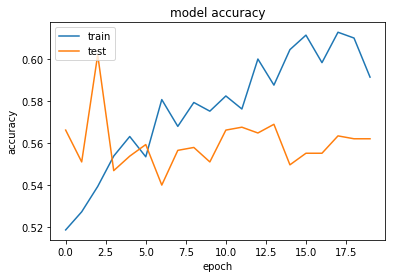

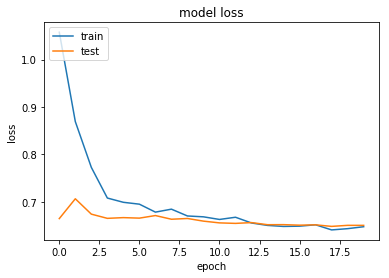

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [27]:
y_pred = model.predict_classes(X_test)


In [28]:

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

0.5689084895259096


In [29]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model55.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model55.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model


Saved model to disk
